2024-09-23 16:11:14,231 - INFO - Data loaded and concatenated. Total rows: 4000, Total columns: 32
2024-09-23 16:11:14,344 - INFO - Data preprocessing complete. Shape after preprocessing: (4000, 1665)
2024-09-23 16:11:14,378 - INFO - DataLoader created with batch size 64.
2024-09-23 16:11:14,385 - INFO - Autoencoder initialized with input size 1665.
2024-09-23 16:11:14,726 - INFO - Epoch 1/50, Loss: 0.010112221352756023
2024-09-23 16:11:15,071 - INFO - Epoch 2/50, Loss: 0.01031735073775053
2024-09-23 16:11:15,554 - INFO - Epoch 3/50, Loss: 0.0073198131285607815
2024-09-23 16:11:15,911 - INFO - Epoch 4/50, Loss: 0.008834164589643478
2024-09-23 16:11:16,211 - INFO - Epoch 5/50, Loss: 0.008485555648803711
2024-09-23 16:11:16,506 - INFO - Epoch 6/50, Loss: 0.009426113218069077
2024-09-23 16:11:16,827 - INFO - Epoch 7/50, Loss: 0.008814612403512001
2024-09-23 16:11:17,206 - INFO - Epoch 8/50, Loss: 0.007282983511686325
2024-09-23 16:11:17,651 - INFO - Epoch 9/50, Loss: 0.008553917519748211


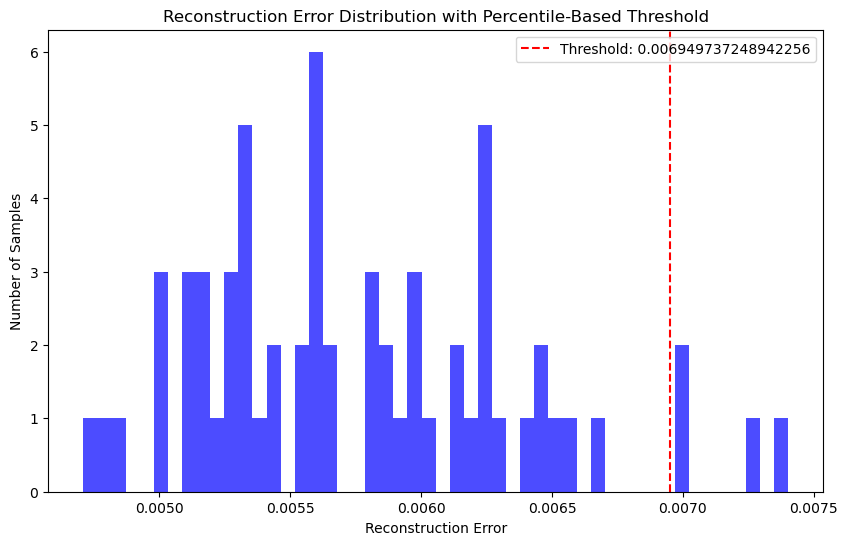

2024-09-23 16:11:39,964 - INFO - Anomalies detected at rows: [3, 8, 49]
2024-09-23 16:11:39,966 - INFO - Reconstruction error values of anomalies: [0.007306455634534359, 0.0069578117690980434, 0.007256641518324614]
2024-09-23 16:11:39,969 - WARNING - Driver Alert: Critical anomaly detected at row 3, reconstruction error: 0.007306455634534359
2024-09-23 16:11:39,969 - WARNING - Driver Alert: Critical anomaly detected at row 8, reconstruction error: 0.0069578117690980434
2024-09-23 16:11:39,970 - WARNING - Driver Alert: Critical anomaly detected at row 49, reconstruction error: 0.007256641518324614
2024-09-23 16:11:39,972 - ERROR - ECU ECU_1 isolated due to suspicious activity.
2024-09-23 16:11:39,977 - INFO - Real-time Reconstruction Error: 0.0058279153890907764
2024-09-23 16:11:40,981 - INFO - Real-time Reconstruction Error: 0.005685253068804741
2024-09-23 16:11:41,984 - INFO - Real-time Reconstruction Error: 0.005208306945860386
2024-09-23 16:11:42,988 - INFO - Real-time Reconstructio

In [6]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import logging
import time
import os
import matplotlib.pyplot as plt

# ==============================
# Logging Configuration
# ==============================
logging.basicConfig(
    level=logging.DEBUG,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler("system_log.log"),
        logging.StreamHandler()
    ]
)

# Load the datasets (replace 'path_to_*' with actual file paths)
data_path = '../data/'

# Load the datasets
dos_data = pd.read_csv(os.path.join(data_path, 'DoS_dataset.csv'), nrows=1000) 
fuzzy_data = pd.read_csv(os.path.join(data_path, 'Fuzzy_dataset.csv'),nrows=1000)
gear_data = pd.read_csv(os.path.join(data_path, 'gear_dataset.csv'), nrows=1000)
rpm_data = pd.read_csv(os.path.join(data_path, 'RPM_dataset.csv'), nrows=1000)

# Concatenate datasets
data = pd.concat([dos_data, fuzzy_data, gear_data, rpm_data], axis=0)
logging.info(f"Data loaded and concatenated. Total rows: {data.shape[0]}, Total columns: {data.shape[1]}")

# Separate numeric and categorical columns
numeric_features = data.select_dtypes(include=['float64', 'int64']).columns
categorical_features = data.select_dtypes(include=['object']).columns

# Define preprocessing for numeric features (impute missing values with mean, scale them)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

# Define preprocessing for categorical features (impute missing values with mode, one-hot encode them)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

# Combine both transformers into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Apply transformations to the data
data_preprocessed = preprocessor.fit_transform(data)
logging.info(f"Data preprocessing complete. Shape after preprocessing: {data_preprocessed.shape}")

# Convert the processed data into a PyTorch tensor
data_tensor = torch.tensor(data_preprocessed, dtype=torch.float32)

# Create DataLoader
batch_size = 64
dataset = TensorDataset(data_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
logging.info(f"DataLoader created with batch size {batch_size}.")

# ==============================
# Autoencoder Model
# ==============================
class Autoencoder(nn.Module):
    def __init__(self, input_size):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16)
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_size),
            nn.Sigmoid())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Initialize the Autoencoder
input_size = data_preprocessed.shape[1]
model = Autoencoder(input_size)
logging.info(f"Autoencoder initialized with input size {input_size}.")

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the Autoencoder
num_epochs = 50
for epoch in range(num_epochs):
    for batch in dataloader:
        inputs = batch[0]
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
    
    logging.info(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

# ==============================
# Anomaly Detection and Evaluation
# ==============================
def calculate_reconstruction_errors(data_loader, model):
    model.eval()
    reconstruction_errors = []
    for batch in data_loader:
        inputs = batch[0]
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        reconstruction_errors.append(loss.item())
    logging.info("Reconstruction errors calculated.")
    return reconstruction_errors

# Calculate reconstruction errors
reconstruction_errors = calculate_reconstruction_errors(dataloader, model)

# ==============================
# Fine-Tuning Threshold with Percentile
# ==============================
def set_threshold_based_on_percentile(reconstruction_errors, percentile=95):
    threshold = np.percentile(reconstruction_errors, percentile)
    logging.info(f"Threshold set at {percentile}th percentile: {threshold}")
    return threshold

# Set the threshold based on the 95th percentile
threshold = set_threshold_based_on_percentile(reconstruction_errors, percentile=95)

# ==============================
# Visualization of Reconstruction Errors
# ==============================
plt.figure(figsize=(10, 6))
plt.hist(reconstruction_errors, bins=50, color='blue', alpha=0.7)
plt.axvline(x=threshold, color='red', linestyle='--', label=f'Threshold: {threshold}')
plt.title('Reconstruction Error Distribution with Percentile-Based Threshold')
plt.xlabel('Reconstruction Error')
plt.ylabel('Number of Samples')
plt.legend()
plt.show()

# ==============================
# Anomaly Detection with Percentile-Based Threshold
# ==============================
def detect_anomalies_with_values(data_loader, model, threshold):
    model.eval()
    anomalies = []
    anomaly_indices = []
    anomaly_values = []
    idx = 0
    for batch in data_loader:
        inputs = batch[0]
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        reconstruction_error = loss.item()
        
        if reconstruction_error > threshold:
            anomalies.append(inputs)
            anomaly_indices.append(idx)
            anomaly_values.append(reconstruction_error)
        idx += 1
    
    logging.info(f"Anomalies detected at rows: {anomaly_indices}")
    logging.info(f"Reconstruction error values of anomalies: {anomaly_values}")
    return anomalies, anomaly_indices, anomaly_values

# Detect anomalies and their values based on the threshold
anomalies, anomaly_indices, anomaly_values = detect_anomalies_with_values(dataloader, model,
                                                                          
                                                                          
                                                                          threshold)










# # ==============================
# # Mitigation Process
# # ==============================
# def alert_driver(message):
#     logging.warning(f"Driver Alert: {message}")

# def isolate_ecu(ecu_id):
#     logging.error(f"ECU {ecu_id} isolated due to suspicious activity.")

# def trigger_safe_mode():
#     logging.critical("Safe mode activated due to critical anomaly detection.")

# # A. Alert the driver for each detected anomaly
# for idx in anomaly_indices:
#     alert_driver(f"Critical anomaly detected at row {idx}, reconstruction error: {anomaly_values[anomaly_indices.index(idx)]}")

# # B. Isolate the ECU if anomalies are detected
# if len(anomaly_indices) > 0:
#     isolate_ecu('ECU_1')

# # C. Trigger safe mode if too many anomalies are detected
# if len(anomaly_indices) > 5:
#     trigger_safe_mode()

# # ==============================
# # Real-Time Monitoring Simulation
# # ==============================
# def real_time_monitoring(data_loader, model, threshold):
#     model.eval()
#     for batch in data_loader:
#         inputs = batch[0]
#         outputs = model(inputs)
#         reconstruction_error = criterion(outputs, inputs).item()
        
#         logging.info(f"Real-time Reconstruction Error: {reconstruction_error}")
        
#         if reconstruction_error > threshold:
#             logging.warning(f"Real-time Anomaly detected with error: {reconstruction_error}")
#             alert_driver(f"Real-time anomaly detected with error {reconstruction_error}")
#             isolate_ecu('ECU_1')
#         time.sleep(1)

# # Simulate real-time monitoring
# real_time_monitoring(dataloader, model, threshold)


2024-09-24 00:04:45,145 - INFO - Data loaded and concatenated. Total rows: 4000, Total columns: 32
2024-09-24 00:04:45,251 - INFO - Data preprocessing complete. Shape after preprocessing: (4000, 1665)
2024-09-24 00:04:45,259 - INFO - DataLoader created with batch size 64.
2024-09-24 00:04:45,263 - INFO - Autoencoder initialized with input size 1665.
2024-09-24 00:04:45,571 - INFO - Epoch 1/50, Loss: 0.009113223291933537
2024-09-24 00:04:45,833 - INFO - Epoch 2/50, Loss: 0.007968276739120483
2024-09-24 00:04:46,111 - INFO - Epoch 3/50, Loss: 0.008324051275849342
2024-09-24 00:04:46,349 - INFO - Epoch 4/50, Loss: 0.010028773918747902
2024-09-24 00:04:46,622 - INFO - Epoch 5/50, Loss: 0.01019489485770464
2024-09-24 00:04:46,933 - INFO - Epoch 6/50, Loss: 0.008957810699939728
2024-09-24 00:04:47,314 - INFO - Epoch 7/50, Loss: 0.009035689756274223
2024-09-24 00:04:47,723 - INFO - Epoch 8/50, Loss: 0.008300002664327621
2024-09-24 00:04:48,347 - INFO - Epoch 9/50, Loss: 0.009081851691007614
2

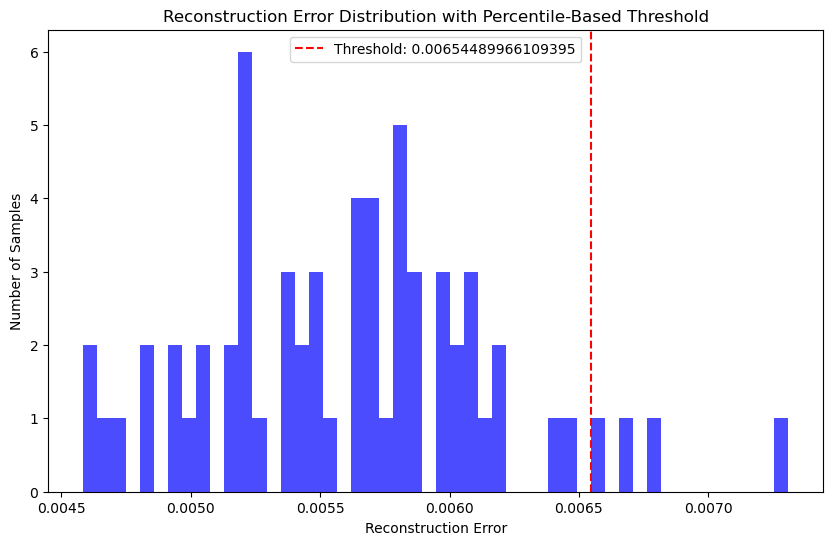

2024-09-24 00:05:15,178 - INFO - Real-time Reconstruction Error: 0.005451798439025879
2024-09-24 00:05:16,185 - INFO - Real-time Reconstruction Error: 0.005694173276424408
2024-09-24 00:05:17,190 - INFO - Real-time Reconstruction Error: 0.004662058316171169
2024-09-24 00:05:18,194 - INFO - Real-time Reconstruction Error: 0.005598802585154772
2024-09-24 00:05:19,198 - INFO - Real-time Reconstruction Error: 0.006518124137073755
2024-09-24 00:05:20,201 - INFO - Real-time Reconstruction Error: 0.006049507763236761
2024-09-24 00:05:21,207 - INFO - Real-time Reconstruction Error: 0.0055099003948271275
2024-09-24 00:05:22,213 - INFO - Real-time Reconstruction Error: 0.004577794577926397
2024-09-24 00:05:23,217 - INFO - Real-time Reconstruction Error: 0.004990308545529842
2024-09-24 00:05:24,220 - INFO - Real-time Reconstruction Error: 0.005308454390615225
2024-09-24 00:05:25,226 - INFO - Real-time Reconstruction Error: 0.005639235954731703
2024-09-24 00:05:26,231 - INFO - Real-time Reconstruc

In [8]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import logging
import time
import os
import matplotlib.pyplot as plt
import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart

# ==============================
# Logging Configuration
# ==============================
logging.basicConfig(
    level=logging.DEBUG,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler("system_log.log"),
        logging.StreamHandler()
    ]
)

# Load the datasets (replace 'path_to_*' with actual file paths)
data_path = '../data/'

# Load the datasets
dos_data = pd.read_csv(os.path.join(data_path, 'DoS_dataset.csv'), nrows=1000) 
fuzzy_data = pd.read_csv(os.path.join(data_path, 'Fuzzy_dataset.csv'),nrows=1000)
gear_data = pd.read_csv(os.path.join(data_path, 'gear_dataset.csv'), nrows=1000)
rpm_data = pd.read_csv(os.path.join(data_path, 'RPM_dataset.csv'), nrows=1000)

# Concatenate datasets
data = pd.concat([dos_data, fuzzy_data, gear_data, rpm_data], axis=0)
logging.info(f"Data loaded and concatenated. Total rows: {data.shape[0]}, Total columns: {data.shape[1]}")

# Separate numeric and categorical columns
numeric_features = data.select_dtypes(include=['float64', 'int64']).columns
categorical_features = data.select_dtypes(include=['object']).columns

# Define preprocessing for numeric features (impute missing values with mean, scale them)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

# Define preprocessing for categorical features (impute missing values with mode, one-hot encode them)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

# Combine both transformers into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Apply transformations to the data
data_preprocessed = preprocessor.fit_transform(data)
logging.info(f"Data preprocessing complete. Shape after preprocessing: {data_preprocessed.shape}")

# Convert the processed data into a PyTorch tensor
data_tensor = torch.tensor(data_preprocessed, dtype=torch.float32)

# Create DataLoader
batch_size = 64
dataset = TensorDataset(data_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
logging.info(f"DataLoader created with batch size {batch_size}.")

# ==============================
# Autoencoder Model
# ==============================
class Autoencoder(nn.Module):
    def __init__(self, input_size):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16)
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_size),
            nn.Sigmoid())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Initialize the Autoencoder
input_size = data_preprocessed.shape[1]
model = Autoencoder(input_size)
logging.info(f"Autoencoder initialized with input size {input_size}.")

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the Autoencoder
num_epochs = 50
for epoch in range(num_epochs):
    for batch in dataloader:
        inputs = batch[0]
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
    
    logging.info(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

# ==============================
# Anomaly Detection and Evaluation
# ==============================
def calculate_reconstruction_errors(data_loader, model):
    model.eval()
    reconstruction_errors = []
    for batch in data_loader:
        inputs = batch[0]
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        reconstruction_errors.append(loss.item())
    logging.info("Reconstruction errors calculated.")
    return reconstruction_errors

# Calculate reconstruction errors
reconstruction_errors = calculate_reconstruction_errors(dataloader, model)

# ==============================
# Fine-Tuning Threshold with Percentile
# ==============================
def set_threshold_based_on_percentile(reconstruction_errors, percentile=95):
    threshold = np.percentile(reconstruction_errors, percentile)
    logging.info(f"Threshold set at {percentile}th percentile: {threshold}")
    return threshold

# Set the threshold based on the 95th percentile
threshold = set_threshold_based_on_percentile(reconstruction_errors, percentile=95)

# ==============================
# Visualization of Reconstruction Errors
# ==============================
plt.figure(figsize=(10, 6))
plt.hist(reconstruction_errors, bins=50, color='blue', alpha=0.7)
plt.axvline(x=threshold, color='red', linestyle='--', label=f'Threshold: {threshold}')
plt.title('Reconstruction Error Distribution with Percentile-Based Threshold')
plt.xlabel('Reconstruction Error')
plt.ylabel('Number of Samples')
plt.legend()
plt.show()

# ==============================
# Email Alert Configuration
# ==============================
def send_email_alert(subject, body, to_email):
    # Email configuration
    from_email = 'gopalghule05@gmail.com'  # Sender's email
    from_password = 'Gopal@444110'      # Sender's email password
    smtp_server = 'smtp.gmail.com'
    smtp_port = 587
    
    # Create email message
    msg = MIMEMultipart()
    msg['From'] = from_email
    msg['To'] = to_email
    msg['Subject'] = subject
    msg.attach(MIMEText(body, 'plain'))
    
    # Send the email
    try:
        server = smtplib.SMTP(smtp_server, smtp_port)
        server.starttls()  # Secure the connection
        server.login(from_email, from_password)
        server.sendmail(from_email, to_email, msg.as_string())
        server.quit()
        logging.info(f"Email sent to {to_email} with subject '{subject}'")
    except Exception as e:
        logging.error(f"Failed to send email: {str(e)}")

# ==============================
# Anomaly Detection with Email Alerts
# ==============================
def real_time_monitoring_with_email_alert(data_loader, model, threshold, recipient_email):
    model.eval()
    for batch in data_loader:
        inputs = batch[0]
        outputs = model(inputs)
        reconstruction_error = criterion(outputs, inputs).item()
        
        logging.info(f"Real-time Reconstruction Error: {reconstruction_error}")
        
        if reconstruction_error > threshold:
            logging.warning(f"Real-time Anomaly detected with error: {reconstruction_error}")
            alert_driver(f"Real-time anomaly detected with error {reconstruction_error}")
            isolate_ecu('ECU_1')
            
            # Send an email alert
            subject = "Critical Anomaly Detected in Vehicle"
            body = (f"A real-time anomaly was detected in the vehicle system with a reconstruction "
                    f"error of {reconstruction_error}. Immediate attention is required.")
            send_email_alert(subject, body, recipient_email)
        
        time.sleep(1)

# ==============================
# Mitigation Process
# ==============================
def alert_driver(message):
    logging.warning(f"Driver Alert: {message}")

def isolate_ecu(ecu_id):
    logging.error(f"ECU {ecu_id} isolated due to suspicious activity.")

def trigger_safe_mode():
    logging.critical("Safe mode activated due to critical anomaly detection.")

# Example usage of real-time monitoring with email alerts
recipient_email = 'gopalghule05@example.com'
real_time_monitoring_with_email_alert(dataloader, model, threshold, recipient_email)


In [3]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import logging
import time
import os
import matplotlib.pyplot as plt
import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart

# ==============================
# Logging Configuration
# ==============================
logging.basicConfig(
    level=logging.DEBUG,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler("system_log.log"),
        logging.StreamHandler()
    ]
)

# Load the datasets (replace 'path_to_*' with actual file paths)
data_path = '../data/'

# Load the datasets
dos_data = pd.read_csv(os.path.join(data_path, 'DoS_dataset.csv'), nrows=1000) 
fuzzy_data = pd.read_csv(os.path.join(data_path, 'Fuzzy_dataset.csv'),nrows=1000)
gear_data = pd.read_csv(os.path.join(data_path, 'gear_dataset.csv'), nrows=1000)
rpm_data = pd.read_csv(os.path.join(data_path, 'RPM_dataset.csv'), nrows=1000)

# Concatenate datasets
data = pd.concat([dos_data, fuzzy_data, gear_data, rpm_data], axis=0)
logging.info(f"Data loaded and concatenated. Total rows: {data.shape[0]}, Total columns: {data.shape[1]}")

# Separate numeric and categorical columns
numeric_features = data.select_dtypes(include=['float64', 'int64']).columns
categorical_features = data.select_dtypes(include=['object']).columns

# Define preprocessing for numeric features (impute missing values with mean, scale them)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

# Define preprocessing for categorical features (impute missing values with mode, one-hot encode them)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

# Combine both transformers into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Apply transformations to the data
data_preprocessed = preprocessor.fit_transform(data)
logging.info(f"Data preprocessing complete. Shape after preprocessing: {data_preprocessed.shape}")

# Convert the processed data into a PyTorch tensor
data_tensor = torch.tensor(data_preprocessed, dtype=torch.float32)

# Create DataLoader
batch_size = 64
dataset = TensorDataset(data_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
logging.info(f"DataLoader created with batch size {batch_size}.")

# ==============================
# Autoencoder Model
# ==============================
class Autoencoder(nn.Module):
    def __init__(self, input_size):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16)
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_size),
            nn.Sigmoid())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Initialize the Autoencoder
input_size = data_preprocessed.shape[1]
model = Autoencoder(input_size)
logging.info(f"Autoencoder initialized with input size {input_size}.")

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the Autoencoder
num_epochs = 50
for epoch in range(num_epochs):
    for batch in dataloader:
        inputs = batch[0]
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
    
    logging.info(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

# ==============================
# Anomaly Detection and Evaluation
# ==============================
def calculate_reconstruction_errors(data_loader, model):
    model.eval()
    reconstruction_errors = []
    for batch in data_loader:
        inputs = batch[0]
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        reconstruction_errors.append(loss.item())
    logging.info("Reconstruction errors calculated.")
    return reconstruction_errors

# Calculate reconstruction errors
reconstruction_errors = calculate_reconstruction_errors(dataloader, model)

# ==============================
# Fine-Tuning Threshold with Percentile
# ==============================
def set_threshold_based_on_percentile(reconstruction_errors, percentile=95):
    threshold = np.percentile(reconstruction_errors, percentile)
    logging.info(f"Threshold set at {percentile}th percentile: {threshold}")
    return threshold

# Set the threshold based on the 95th percentile
threshold = set_threshold_based_on_percentile(reconstruction_errors, percentile=95)

# ==============================
# Email Alert Setup
# ==============================
def send_email_alert(subject, message):
    # Define your SMTP email server details (for example, using Gmail's SMTP server)
    smtp_server = "smtp.gmail.com"
    smtp_port = 587
    email_from = "gopalghule05@gmail.com"
    email_to = "gopalghule05@example.com"
    password = "Gopal@444110"
    
    # Create the email message
    msg = MIMEMultipart()
    msg['From'] = email_from
    msg['To'] = email_to
    msg['Subject'] = subject
    msg.attach(MIMEText(message, 'plain'))
    
    # Send the email
    try:
        server = smtplib.SMTP(smtp_server, smtp_port)
        server.starttls()
        server.login(email_from, password)
        server.sendmail(email_from, email_to, msg.as_string())
        server.quit()
        logging.info(f"Email sent to {email_to}")
    except Exception as e:
        logging.error(f"Failed to send email: {e}")

# ==============================
# Mitigation Process with Email Alerts After Mitigation
# ==============================
def alert_driver(message):
    try:
        logging.warning(f"Driver Alert: {message}")
        send_email_alert("Driver Alert", message)
        send_email_alert("Mitigation Action", f"Driver has been alerted: {message}")
        logging.info("Driver alert successfully sent.")
    except Exception as e:
        logging.error(f"Failed to alert driver: {e}")
        send_email_alert("Driver Alert Failure", f"Failed to alert driver: {e}")

def isolate_ecu(ecu_id):
    try:
        logging.error(f"ECU {ecu_id} isolated due to suspicious activity.")
        send_email_alert("ECU Isolation", f"ECU {ecu_id} has been isolated due to suspicious activity.")
        send_email_alert("Mitigation Action", f"Mitigation performed: ECU {ecu_id} isolated.")
        logging.info(f"ECU {ecu_id} isolation successfully performed.")
    except Exception as e:
        logging.error(f"Failed to isolate ECU: {e}")
        send_email_alert("ECU Isolation Failure", f"Failed to isolate ECU {ecu_id}: {e}")

def trigger_safe_mode():
    try:
        logging.critical("Safe mode activated due to critical anomaly detection.")
        send_email_alert("Critical Alert", "Safe mode activated due to critical anomaly detection.")
        send_email_alert("Mitigation Action", "Mitigation performed: Safe mode activated.")
        logging.info("Safe mode successfully triggered.")
    except Exception as e:
        logging.error(f"Failed to trigger safe mode: {e}")
        send_email_alert("Safe Mode Failure", f"Failed to trigger safe mode: {e}")

# ==============================
# Confirmation Step
# ==============================
def check_ecu_isolation(ecu_id):
    # Simulate a check for ECU isolation status (replace with actual check)
    # Example: Query a status API or hardware interface
    isolated = True  # Simulate successful isolation
    if isolated:
        logging.info(f"ECU {ecu_id} isolation confirmed.")
        send_email_alert(f"ECU {ecu_id} Isolation Confirmation", "ECU isolation confirmed.")
    else:
        logging.error(f"Failed to confirm isolation of ECU {ecu_id}.")
        send_email_alert(f"ECU {ecu_id} Isolation Failure", f"Failed to confirm isolation of ECU {ecu_id}.")

# ==============================
# Retry Mechanism
# ==============================
def retry_action(action, max_retries=3):
    for attempt in range(max_retries):
        try:
            action()
            return True  # Action succeeded
        except Exception as e:
            logging.warning(f"Attempt {attempt + 1} failed: {e}")
    logging.error(f"Failed to complete {action} after {max_retries} attempts.")
    send_email_alert("Mitigation Action Failure", f"Failed to complete action after {max_retries} attempts.")
    return False

# A. Alert the driver for each detected anomaly
retry_action(lambda: alert_driver(f"Critical anomaly detected"))

# B. Isolate the ECU if anomalies are detected
if len(reconstruction_errors) > 0:
    retry_action(lambda: isolate_ecu('ECU_1'))
    check_ecu_isolation('ECU_1')  # Check if isolation was successful

# C. Trigger safe mode if too many anomalies are detected
if len(reconstruction_errors) > 5:
    retry_action(trigger_safe_mode)

# ==============================
# Real-Time Monitoring Simulation
# ==============================
def real_time_monitoring(data_loader, model, threshold):
    model.eval()
    for batch in data_loader:
        inputs = batch[0]
        outputs = model(inputs)
        reconstruction_error = criterion(outputs, inputs).item()
        
        logging.info(f"Real-time Reconstruction Error: {reconstruction_error}")
        
        if reconstruction_error > threshold:
            logging.warning(f"Real-time Anomaly detected with error: {reconstruction_error}")
            retry_action(lambda: alert_driver(f"Real-time anomaly detected with error {reconstruction_error}"))
            retry_action(lambda: isolate_ecu('ECU_1'))
        time.sleep(1)

# Simulate real-time monitoring
real_time_monitoring(dataloader, model, threshold)


2024-09-25 11:56:15,620 - INFO - Data loaded and concatenated. Total rows: 4000, Total columns: 32
2024-09-25 11:56:15,827 - INFO - Data preprocessing complete. Shape after preprocessing: (4000, 1665)
2024-09-25 11:56:15,883 - INFO - DataLoader created with batch size 64.
2024-09-25 11:56:15,901 - INFO - Autoencoder initialized with input size 1665.
2024-09-25 11:56:20,089 - INFO - Epoch 1/50, Loss: 0.008828512392938137
2024-09-25 11:56:20,640 - INFO - Epoch 2/50, Loss: 0.007014087401330471
2024-09-25 11:56:21,132 - INFO - Epoch 3/50, Loss: 0.0069675869308412075
2024-09-25 11:56:21,560 - INFO - Epoch 4/50, Loss: 0.0107344388961792
2024-09-25 11:56:21,944 - INFO - Epoch 5/50, Loss: 0.009556780569255352
2024-09-25 11:56:22,319 - INFO - Epoch 6/50, Loss: 0.00891880877315998
2024-09-25 11:56:22,682 - INFO - Epoch 7/50, Loss: 0.010092606768012047
2024-09-25 11:56:23,088 - INFO - Epoch 8/50, Loss: 0.01032294426113367
2024-09-25 11:56:23,520 - INFO - Epoch 9/50, Loss: 0.006948442198336124
202

In [3]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import logging
import time
import os
import matplotlib.pyplot as plt
import smtplib
from email.message import EmailMessage

# ==============================
# Logging Configuration
# ==============================
logging.basicConfig(
    level=logging.DEBUG,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler("system_log.log"),
        logging.StreamHandler()
    ]
)

# Load the datasets (replace 'path_to_*' with actual file paths)
data_path = '../data/'

# Load the datasets
dos_data = pd.read_csv(os.path.join(data_path, 'DoS_dataset.csv'), nrows=1000) 
fuzzy_data = pd.read_csv(os.path.join(data_path, 'Fuzzy_dataset.csv'),nrows=1000)
gear_data = pd.read_csv(os.path.join(data_path, 'gear_dataset.csv'), nrows=1000)
rpm_data = pd.read_csv(os.path.join(data_path, 'RPM_dataset.csv'), nrows=1000)

# Concatenate datasets
data = pd.concat([dos_data, fuzzy_data, gear_data, rpm_data], axis=0)
logging.info(f"Data loaded and concatenated. Total rows: {data.shape[0]}, Total columns: {data.shape[1]}")

# Separate numeric and categorical columns
numeric_features = data.select_dtypes(include=['float64', 'int64']).columns
categorical_features = data.select_dtypes(include=['object']).columns

# Define preprocessing for numeric features (impute missing values with mean, scale them)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

# Define preprocessing for categorical features (impute missing values with mode, one-hot encode them)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

# Combine both transformers into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Apply transformations to the data
data_preprocessed = preprocessor.fit_transform(data)
logging.info(f"Data preprocessing complete. Shape after preprocessing: {data_preprocessed.shape}")

# Convert the processed data into a PyTorch tensor
data_tensor = torch.tensor(data_preprocessed, dtype=torch.float32)

# Create DataLoader
batch_size = 64
dataset = TensorDataset(data_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
logging.info(f"DataLoader created with batch size {batch_size}.")

# ==============================
# Autoencoder Model
# ==============================
class Autoencoder(nn.Module):
    def __init__(self, input_size):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16)
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_size),
            nn.Sigmoid())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Initialize the Autoencoder
input_size = data_preprocessed.shape[1]
model = Autoencoder(input_size)
logging.info(f"Autoencoder initialized with input size {input_size}.")

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the Autoencoder
num_epochs = 50
for epoch in range(num_epochs):
    for batch in dataloader:
        inputs = batch[0]
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
    
    logging.info(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

# ==============================
# Anomaly Detection and Evaluation
# ==============================
def calculate_reconstruction_errors(data_loader, model):
    model.eval()
    reconstruction_errors = []
    for batch in data_loader:
        inputs = batch[0]
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        reconstruction_errors.append(loss.item())
    logging.info("Reconstruction errors calculated.")
    return reconstruction_errors

# Calculate reconstruction errors
reconstruction_errors = calculate_reconstruction_errors(dataloader, model)

# ==============================
# Fine-Tuning Threshold with Percentile
# ==============================
def set_threshold_based_on_percentile(reconstruction_errors, percentile=95):
    threshold = np.percentile(reconstruction_errors, percentile)
    logging.info(f"Threshold set at {percentile}th percentile: {threshold}")
    return threshold

# Set the threshold based on the 95th percentile
threshold = set_threshold_based_on_percentile(reconstruction_errors, percentile=95)

# ==============================
# Email Alert Setup (Using EmailMessage)
# ==============================
def send_email_alert(subject, message):
    # Define your SMTP email server details (for example, using Gmail's SMTP server)
    smtp_server = "smtp.gmail.com"
    smtp_port = 587
    email_from = "gopalghule05@gmail.com"
    email_to = "gopalghule05@example.com"
    password = "weyaycicumjfnxnn"
    
    # Create the email message
    email_msg = EmailMessage()
    email_msg['From'] = email_from
    email_msg['To'] = email_to
    email_msg['Subject'] = subject
    email_msg.set_content(message)
    
    # Send the email
    try:
        server = smtplib.SMTP(smtp_server, smtp_port)
        server.starttls()
        server.login(email_from, password)
        server.send_message(email_msg)
        server.quit()
        logging.info(f"Email sent to {email_to}")
    except Exception as e:
        logging.error(f"Failed to send email: {e}")

# ==============================
# Mitigation Process with Email Alerts After Mitigation
# ==============================
def alert_driver(message):
    try:
        logging.warning(f"Driver Alert: {message}")
        send_email_alert("Driver Alert", message)
        send_email_alert("Mitigation Action", f"Driver has been alerted: {message}")
        logging.info("Driver alert successfully sent.")
    except Exception as e:
        logging.error(f"Failed to alert driver: {e}")
        send_email_alert("Driver Alert Failure", f"Failed to alert driver: {e}")

def isolate_ecu(ecu_id):
    try:
        logging.error(f"ECU {ecu_id} isolated due to suspicious activity.")
        send_email_alert("ECU Isolation", f"ECU {ecu_id} has been isolated due to suspicious activity.")
        send_email_alert("Mitigation Action", f"Mitigation performed: ECU {ecu_id} isolated.")
        logging.info(f"ECU {ecu_id} isolation successfully performed.")
    except Exception as e:
        logging.error(f"Failed to isolate ECU: {e}")
        send_email_alert("ECU Isolation Failure", f"Failed to isolate ECU {ecu_id}: {e}")

def trigger_safe_mode():
    try:
        logging.critical("Safe mode activated due to critical anomaly detection.")
        send_email_alert("Critical Alert", "Safe mode activated due to critical anomaly detection.")
        send_email_alert("Mitigation Action", "Mitigation performed: Safe mode activated.")
        logging.info("Safe mode successfully triggered.")
    except Exception as e:
        logging.error(f"Failed to trigger safe mode: {e}")
        send_email_alert("Safe Mode Failure", f"Failed to trigger safe mode: {e}")

# ==============================
# Confirmation Step
# ==============================
def check_ecu_isolation(ecu_id):
    # Simulate a check for ECU isolation status (replace with actual check)
    isolated = True  # Simulate successful isolation
    if isolated:
        logging.info(f"ECU {ecu_id} isolation confirmed.")
        send_email_alert(f"ECU {ecu_id} Isolation Confirmation", "ECU isolation confirmed.")
    else:
        logging.error(f"Failed to confirm isolation of ECU {ecu_id}.")
        send_email_alert(f"ECU {ecu_id} Isolation Failure", f"Failed to confirm isolation of ECU {ecu_id}.")

# ==============================
# Retry Mechanism
# ==============================
def retry_action(action, max_retries=3):
    for attempt in range(max_retries):
        try:
            action()
            return True  # Action succeeded
        except Exception as e:
            logging.warning(f"Attempt {attempt + 1} failed: {e}")
    logging.error(f"Failed to complete {action} after {max_retries} attempts.")
    send_email_alert("Mitigation Action Failure", f"Failed to complete action after {max_retries} attempts.")
    return False

# A. Alert the driver for each detected anomaly
retry_action(lambda: alert_driver(f"Critical anomaly detected"))

# B. Isolate the ECU if anomalies are detected
if len(reconstruction_errors) > 0:
    retry_action(lambda: isolate_ecu('ECU_1'))
    check_ecu_isolation('ECU_1')  # Check if isolation was successful

# C. Trigger safe mode if too many anomalies are detected
if len(reconstruction_errors) > 5:
    retry_action(trigger_safe_mode)

# ==============================
# Real-Time Monitoring Simulation
# ==============================
def real_time_monitoring(data_loader, model, threshold):
    model.eval()
    for batch in data_loader:
        inputs = batch[0]
        outputs = model(inputs)
        reconstruction_error = criterion(outputs, inputs).item()
        
        logging.info(f"Real-time Reconstruction Error: {reconstruction_error}")
        
        if reconstruction_error > threshold:
            logging.warning(f"Real-time Anomaly detected with error: {reconstruction_error}")
            retry_action(lambda: alert_driver(f"Real-time anomaly detected with error {reconstruction_error}"))
            retry_action(lambda: isolate_ecu('ECU_1'))
        time.sleep(1)

# Simulate real-time monitoring
real_time_monitoring(dataloader, model, threshold)


2024-09-25 20:51:25,247 - INFO - Data loaded and concatenated. Total rows: 4000, Total columns: 32
2024-09-25 20:51:25,409 - INFO - Data preprocessing complete. Shape after preprocessing: (4000, 1665)
2024-09-25 20:51:25,423 - INFO - DataLoader created with batch size 64.
2024-09-25 20:51:25,430 - INFO - Autoencoder initialized with input size 1665.
2024-09-25 20:51:27,759 - INFO - Epoch 1/50, Loss: 0.00911305658519268
2024-09-25 20:51:28,329 - INFO - Epoch 2/50, Loss: 0.007537493482232094
2024-09-25 20:51:28,911 - INFO - Epoch 3/50, Loss: 0.007871277630329132
2024-09-25 20:51:29,423 - INFO - Epoch 4/50, Loss: 0.009220664389431477
2024-09-25 20:51:29,962 - INFO - Epoch 5/50, Loss: 0.007651627995073795
2024-09-25 20:51:30,536 - INFO - Epoch 6/50, Loss: 0.008283832110464573
2024-09-25 20:51:31,033 - INFO - Epoch 7/50, Loss: 0.008331406861543655
2024-09-25 20:51:31,472 - INFO - Epoch 8/50, Loss: 0.010006186552345753
2024-09-25 20:51:32,040 - INFO - Epoch 9/50, Loss: 0.008681485429406166
2